In [10]:
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding as LLE

import plotly.graph_objects as go

from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

from ripser import ripser
from persim import plot_diagrams
from numpy import sin,cos, dot
import numpy as np
from numpy import pi,cos,sin
import matplotlib.pyplot as plt
import random

In [2]:
def graph_continuous(image_function, x, y, x_random = True, n_samples= 100000, y_random = True):
    
    if x_random == True:
        X = list(2 * x * np.random.random(n_samples) - x) 
        if y_random == True:
            Y = list(2 * y * np.random.random(n_samples) - y) 
        else:
            Y = np.linspace(-y,y,n_samples)      

    if x_random == False:
        X = np.linspace(-x,x,n_samples)
        if y_random == True:
            Y = list(2 * y * np.random.random(n_samples) - y) 
        else:
            Y = np.linspace(-y,y,n_samples)   

    x_points = []
    y_points = []
    colors = []
    for i in range(n_samples):
        color = image_function(X[i],Y[i]) 
        colors.append(color)
        x_points.append(X[i])
        y_points.append(Y[i])

        
    fig = plt.figure(figsize = (7, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points, c = colors, s = .1)
    plt.show()
    
    
def view_window_continuous(image_function, num_pixels, window_size):
    
    pixels = get_pixels(num_pixels, window_size)
            
    x_points = []
    y_points = []
    colors = []
    for i in range(len(pixels)):
        color = image_function(pixels[i][0],pixels[i][1]) 
        colors.append(color)
        x_points.append(pixels[i][0])
        y_points.append(pixels[i][1])
    
    fig = plt.figure(figsize = (7, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points, c = colors)
    plt.show()

In [3]:
def get_pixels(num_pixels, window_size):
    sample = list(np.linspace(-window_size/2, window_size/2, num_pixels))
    pixels = []
    for i in range(len(sample)):
        for j in range(len(sample)):
            pixels.append((sample[i],sample[j]))     
    return pixels


def get_colors(pixels, image_function):
    colors = []
    for pixel in pixels:
        colors.append(image_function(pixel[0],pixel[1]))
    return colors  

def translation(a,b):
    def t_ab(x,y): 
        return x+a, y+b
    return t_ab

def rotation(theta):
    def r_theta(x,y):
        return x * cos(theta) - y * sin(theta), x * sin(theta) + y * cos(theta)
    return r_theta

def isom(a,b,theta):
    def iso(x,y):
        r = rotation(theta)
        t = translation(a,b)
        return t(r(x,y)[0], r(x,y)[1])
    return iso

def generate_isom(n_isos, x_translate, y_translate):
    a = list(2 * x_translate * np.random.random(n_isos) - x_translate) # sampling from (-x,x)
    b = list(2 * y_translate * np.random.random(n_isos) - y_translate) # sampling from (-y,y)
    theta = list(2 * pi * np.random.random(n_isos)) # sampling from (0, 2pi)

    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i],2 * pi - theta[i])) 
    return isos_inv

def new_colors(pixels, iso_inv, image_function):
    pixels_inv = []
    for pixel in pixels: 
        pixels_inv.append(iso_inv(pixel[0], pixel[1]))
    new_colors = get_colors(pixels_inv, image_function)
    return new_colors

def matrix_of_images(pixels, isos_inv, image_function):
    vectors = []
    for i in isos_inv:
        vectors.append([new_colors(pixels, i, image_function)])
    M = np.concatenate(vectors, axis=0 )
    return M

def p_hom(M, maxdim, coeff):
    output = ripser(M, maxdim = maxdim, coeff = coeff)
    return output
    
def persistent_H1_intervals(output):
    H1 = output['dgms'][1].tolist() # all intervals in H1
    d = []
    for pair in H1: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    d.sort(reverse = True) # sorting from longest to shortest intervals
    d
    return d

def plot_dgms(output):
    dgms = output['dgms']
    fig = plt.figure(figsize = (12, 6))
    plot_diagrams(dgms)
    
def pipeline(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

In [6]:
def data_matrix(image_function, num_pixels, window_size, n_isos, x_translate, y_translate):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    return M

In [4]:
def p3_sin(x,y):
    X = 1/(2 * pi) * (x + y / (3**(1/2)))
    Y = 1/(2 * pi) * 2 * y / (3**(1/2))
    C = cos(X + Y) + cos(X - 2 * Y) + cos(-2 * X + Y)
    S = sin(X + Y) +sin(X - 2*Y) +sin(-2 * X + Y)
    return S

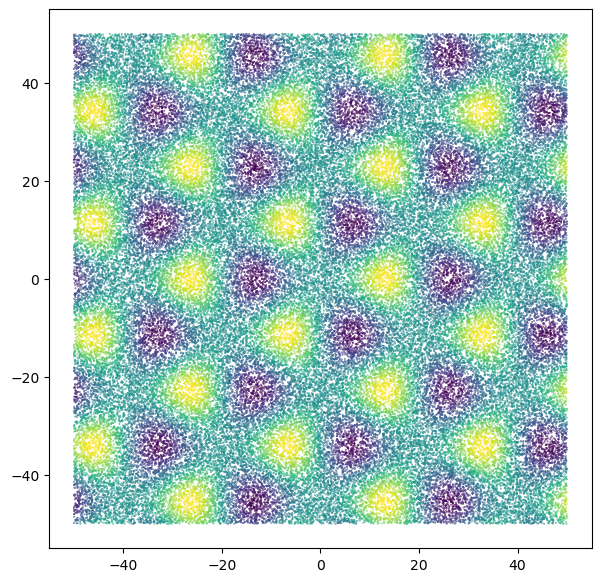

In [5]:
graph_continuous(p3_sin, 50,50)

In [7]:
M = data_matrix(image_function = p3_sin, num_pixels = 40 , window_size = 50, n_isos = 2000, x_translate= 200 , y_translate=200)

In [12]:
#PCA
pca = PCA(n_components=4)
data_pca = pca.fit(M).transform(M)


fig = go.Figure(data=[go.Scatter3d(
    x=data_pca[:,0], y=data_pca[:,1], z=data_pca[:,2], 
    mode ='markers', 
)])

fig.update_layout(autosize=False, width=700, height=700)

fig.show()

In [13]:
def p3(x,y):
    X = 1/(2 * pi) * (x + y / (3**(1/2)))
    Y = 1/(2 * pi) * 2 * y / (3**(1/2))
    C = cos(X + Y) + cos(X - 2 * Y) + cos(-2 * X + Y)
    S = sin(X + Y) +sin(X - 2*Y) +sin(-2 * X + Y)
    return C + S

In [16]:
M = data_matrix(image_function = p3, num_pixels = 40 , window_size = 50, n_isos = 2000, x_translate= 1000 , y_translate=1000)

In [17]:
#PCA
pca = PCA(n_components=4)
data_pca = pca.fit(M).transform(M)


fig = go.Figure(data=[go.Scatter3d(
    x=data_pca[:,0], y=data_pca[:,1], z=data_pca[:,2], 
    mode ='markers', 
)])

fig.update_layout(autosize=False, width=700, height=700)

fig.show()

In [18]:
def p6(x,y):
    X = 1/(2 * pi) * (x + y / (3**(1/2)))
    Y = 1/(2 * pi) * 2 * y / (3**(1/2))
    C = cos(X + Y) + cos(X - 2 * Y) + cos(-2 * X + Y)
    S = sin(X + Y) +sin(X - 2*Y) +sin(-2 * X + Y)
    return C 

In [19]:
M = data_matrix(image_function = p6, num_pixels = 40 , window_size = 50, n_isos = 2000, x_translate= 1000 , y_translate=1000)

In [21]:
#PCA
pca = PCA(n_components=4)
data_pca = pca.fit(M).transform(M)

fig = go.Figure(data=[go.Scatter3d(
    x=data_pca[:,0], y=data_pca[:,1], z=data_pca[:,2], 
    mode ='markers', 
)])

fig.update_layout(autosize=False, width=700, height=700)

fig.show()